In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns


In [2]:
mlflow.set_tracking_uri("file:///afs/cern.ch/work/p/phploner/foundation_model_testing/logs/mlflow/mlruns")
client = mlflow.tracking.MlflowClient()
exp = client.get_experiment_by_name("hyperparameter_search")
exp_id = exp.experiment_id
runs = client.search_runs(
    experiment_ids=[exp_id],
    filter_string="attributes.status = 'FINISHED'",
    max_results=1000,
)
print("Found runs:", len(runs))


/afs/.cern.ch/work/p/phploner/conda_envs/fm_testing/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


Found runs: 50


In [3]:
runs[0].info.run_name

'Optimized_upscaled_v2_JetsAndMoreReducedParticles'

In [4]:
rows = []
for r in runs:
    rows.append({
        "run_name": r.data.tags.get("mlflow.runName"),
        "val_acc": r.data.metrics.get("val/acc_best"),
        "val_auroc": r.data.metrics.get("val/auroc_best"),
        "lr": float(r.data.params["model/optimizer/lr"]),
        "wd": float(r.data.params["model/optimizer/weight_decay"]),
        "d_ff": int(r.data.params["model/d_ff"]),
        "layers": int(r.data.params["model/num_layers"]),
        "tpr_at_1e-2_fpr": float(r.data.metrics["val/tpr_macro_at_1e-2"]),
        "run_id": r.info.run_id,
    })

df = pd.DataFrame(rows)
df.head()

,run_name,val_acc,val_auroc,lr,wd,d_ff,layers,tpr_at_1e-2_fpr,run_id
0,Optimized_upscaled_v2_JetsAndMoreReducedParticles,0.936575,0.974162,0.0002,0.01,256,4,0.597752,8ba31daf69a14710a174ef7ca8ea119f
1,Optimized_upscaled_v2_JetsAndReducedParticles,0.937275,0.974224,0.0002,0.01,256,4,0.584276,67e288ebad994abaa237c04effd3b4b1
2,Optimized_upscaled_v2_onlyMisc,0.579475,0.662479,0.0002,0.01,256,4,0.091790,af7818f2cfd4488ebb376f06589dec9f
3,Optimized_upscaled_v2_onlyJets,0.935200,0.972745,0.0002,0.01,256,4,0.585689,7e9fca3c931a48dd8e3c123f80e1ba2d
4,Optimized_upscaled_v2_JetsAndParticles,0.936625,0.974778,0.0002,0.01,256,4,0.597283,fe2445ab48c34a96b82972205ed9ad74


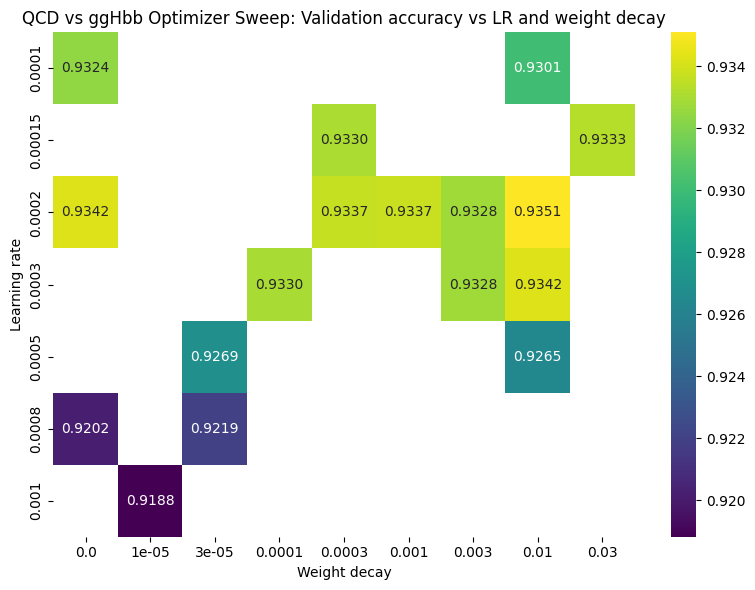

In [6]:
df_opt = df[df.run_name == "Optimizer_sweep"]

pivot = df_opt.pivot_table(
    values="val_acc",
    index="lr",
    columns="wd",
    aggfunc="max"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("QCD vs ggHbb Optimizer Sweep: Validation accuracy vs LR and weight decay")
plt.ylabel("Learning rate")
plt.xlabel("Weight decay")
plt.tight_layout()
plt.show()

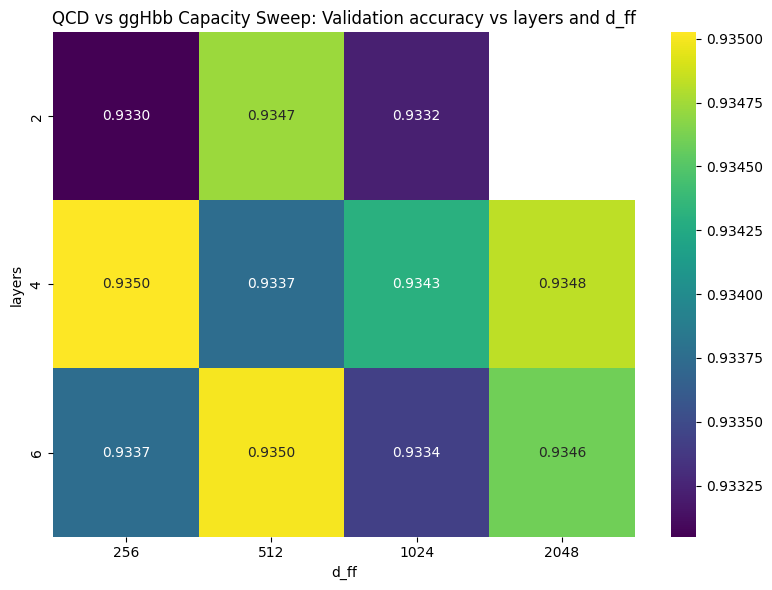

In [7]:
df_cap = df[df.run_name == "Capacity_sweep"]

pivot = df_cap.pivot_table(
    values="val_acc",
    index="layers",
    columns="d_ff",
    aggfunc="max"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("QCD vs ggHbb Capacity Sweep: Validation accuracy vs layers and d_ff")
plt.ylabel("layers")
plt.xlabel("d_ff")
plt.tight_layout()
plt.show()


In [9]:
mlflow.set_tracking_uri("file:///afs/cern.ch/work/p/phploner/foundation_model_testing/logs/mlflow/mlruns")
client = mlflow.tracking.MlflowClient()
exp = client.get_experiment_by_name("hyperparameter_search")
exp_id = exp.experiment_id
runs = client.search_runs(
    experiment_ids=[exp_id],
    filter_string="attribute.run_name LIKE 'Optimized_upscaled_v2%'",
    max_results=1000,
)
print("Found runs:", len(runs))


Found runs: 7


In [10]:
curves = []

for run in runs:
    run_id = run.info.run_id
    run_name = run.data.tags.get("mlflow.runName", run_id[:8])

    history = client.get_metric_history(run_id, "val/acc")
    history = sorted(history, key=lambda m: (m.timestamp, m.step))

    for epoch_idx, m in enumerate(history):
        curves.append({
            "run_name": run_name,
            "epoch": epoch_idx,  
            "val_acc": m.value,
        })

df = pd.DataFrame(curves)


In [11]:
label_map = {
    "Optimized_upscaled_v2": "20Particles_5Jets_Extra",
    "Optimized_upscaled_v2_onlyJets": "5Jets",
    "Optimized_upscaled_v2_onlyMisc": "Extra",
    "Optimized_upscaled_v2_onlyParticles": "20Particles",
    "Optimized_upscaled_v2_JetsAndParticles": "20Particles_5Jets",
    "Optimized_upscaled_v2_JetsAndReducedParticles": "10Particles_5Jets",
    "Optimized_upscaled_v2_JetsAndMoreReducedParticles": "5Particles_5Jets",
}
df["label"] = df["run_name"].map(label_map)

In [12]:
best = (
    df.groupby("label")["val_acc"]
      .max()
      .sort_values(ascending=False)
)

print(best)

label
10Particles_5Jets          0.937275
20Particles_5Jets          0.936625
5Particles_5Jets           0.936575
20Particles_5Jets_Extra    0.935975
5Jets                      0.935200
20Particles                0.862550
Extra                      0.579475
Name: val_acc, dtype: float64


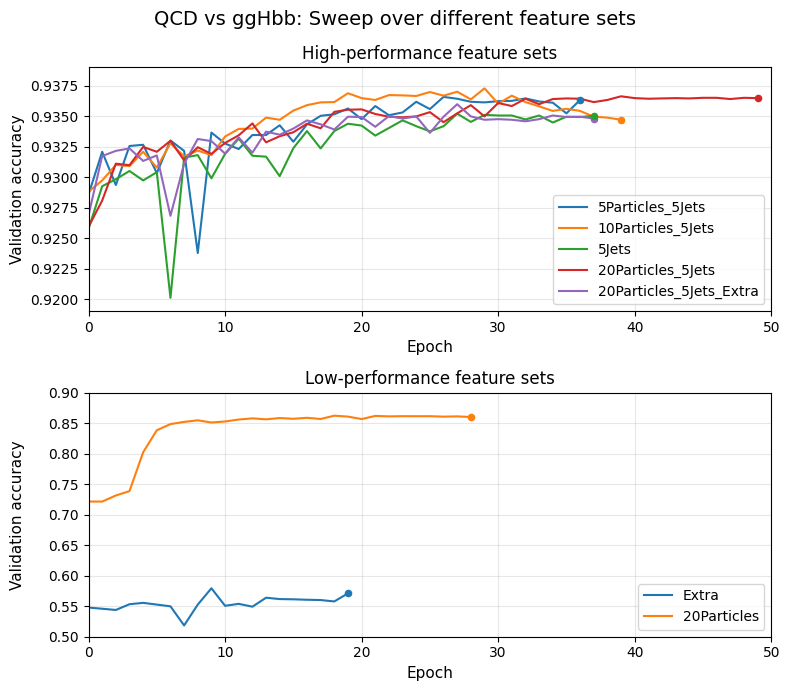

In [16]:
top = df[df["label"].isin(["20Particles_5Jets_Extra","5Jets","20Particles_5Jets","10Particles_5Jets","5Particles_5Jets"])]
bottom = df[~df["label"].isin(top["label"].unique())]

fig, axes = plt.subplots(2, 1, figsize=(8, 7))

sns.lineplot(
    data=top,
    x="epoch",
    y="val_acc",
    hue="label",
    ax=axes[0]
)
axes[0].set_xlim(0, 50)
axes[0].set_ylim(0.919, 0.939)
axes[0].set_title("High-performance feature sets", fontsize=12)
handles, labels = axes[0].get_legend_handles_labels()
color_map = {label: handle.get_color() for handle, label in zip(handles, labels)}

# Plot endpoints with correct colors
for label, g in top.groupby("label"):
    last = g.sort_values("epoch").iloc[-1]
    axes[0].scatter(
        last["epoch"],
        last["val_acc"],
        s=20,
        color=color_map[label],
        zorder=5,
    )

sns.lineplot(
    data=bottom,
    x="epoch",
    y="val_acc",
    hue="label",
    ax=axes[1]
)
axes[1].set_xlim(0, 50)
axes[1].set_ylim(0.5, 0.9)
axes[1].set_title("Low-performance feature sets", fontsize=12)
handles, labels = axes[1].get_legend_handles_labels()
color_map = {label: handle.get_color() for handle, label in zip(handles, labels)}
for label, g in bottom.groupby("label"):
    last = g.sort_values("epoch").iloc[-1]
    axes[1].scatter(
        last["epoch"],
        last["val_acc"],
        s=20,
        color=color_map[label],
        zorder=5,
    )
    
axes[0].legend(title=None, loc='lower right')
axes[1].legend(title=None, loc='lower right')

for ax in axes:
    ax.tick_params(labelsize=10)
    ax.set_xlabel("Epoch", fontsize=11)
    ax.set_ylabel("Validation accuracy", fontsize=11)
    ax.grid(alpha=0.3)
    
fig.align_ylabels(axes)

plt.suptitle("QCD vs ggHbb: Sweep over different feature sets", fontsize=14)

plt.tight_layout()
plt.show()
